In [70]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from glob import glob
from os.path import join, exists
from datetime import datetime
from pyproj import Proj

In [19]:
goes_path = sorted(glob("/glade/p/cisl/aiml/dgagne/goes16_nc/ABI-L1b_conus/20180401/*.nc"))

In [26]:
goes_path[5]

'/glade/p/cisl/aiml/dgagne/goes16_nc/ABI-L1b_conus/20180401/OR_ABI-L1b-RadC-M3C01_G16_s20180910032195_e20180910034568_c20180910035022.nc'

In [30]:
date_str = goes_path[4][:-3].split("/")[-1].split("_")[-1][1:]
print(date_str)
datetime.strptime(date_str, "%Y%j%H%M%S%f")

20180910030011


datetime.datetime(2018, 4, 1, 0, 30, 1, 100000)

In [34]:
def get_goes16_abi_file(date, channel, path):
    pd_date = pd.Timestamp(date)
    channel_files = sorted(glob(join(path, pd_date.strftime("%Y%m%d"), f"OR_ABI-L1b-RadC-M3C{channel:02d}_G16_*.nc")))
    # Date format: Year (%Y), Day of Year (%j), Hour (%H), Minute (%M), Second (%s), Tenth of a second
    # See https://docs.opendata.aws/noaa-goes16/cics-readme.html for more details
    channel_dates = pd.DatetimeIndex([datetime.strptime(c_file[:-3].split("/")[-1].split("_")[-1][1:-1], "%Y%j%H%M%S") for c_file in channel_files])
    file_index = np.where(np.abs(pd_date - channel_dates) < pd.Timedelta(minutes=2))[0]
    if len(file_index) == 0:
        raise FileNotFoundError('No GOES-16 files within 2 minutes of ' + pd_date)
    else:
        filename = channel_files[file_index[0]]
    return filename

In [38]:
abi_path = "/glade/p/cisl/aiml/dgagne/goes16_nc/ABI-L1b_conus"
abi_file = get_goes16_abi_file(pd.Timestamp("2018-05-03 18:45:00"), 14, abi_path)

In [39]:
ds = xr.open_dataset(abi_file)

In [47]:
proj = ccrs.Geostationary(central_longitude=ds["nominal_satellite_subpoint_lon"].values, 
                   satellite_height=ds["nominal_satellite_height"].values * 1000,
                   sweep_axis='x')

In [ ]:
proj.transform_points()

In [71]:
g16_proj = Proj(**proj.proj4_params)

In [104]:
x = ds["x"].values * sat_height * 1000
y = ds["y"].values * sat_height * 1000
xx, yy = np.meshgrid(x, y)
lons, lats = g16_proj(xx, yy, inverse=True)
lons[lons > 1e20] = np.nan
lats[lats > 1e20] = np.nan

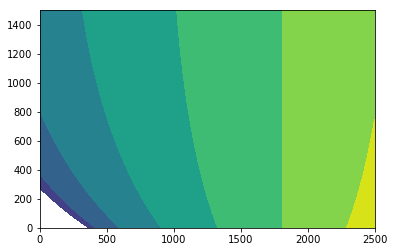

In [90]:
plt.contourf(np.ma.array(lons, mask=lons>1e20))

In [60]:
sat_height = ds["nominal_satellite_height"].values

In [96]:
ds["Rad"]

<xarray.DataArray 'Rad' (y: 1500, x: 2500)>
array([[       nan,        nan,        nan, ...,  67.5209  ,  68.70871 ,
         70.34196 ],
       [       nan,        nan,        nan, ...,  67.71887 ,  68.065315,
         70.24297 ],
       [       nan,        nan,        nan, ...,  68.1643  ,  69.50059 ,
         70.045006],
       ...,
       [ 93.65279 ,  93.65279 ,  91.920555, ..., 108.25298 , 108.40147 ,
        108.40147 ],
       [ 93.65279 ,  93.75177 ,  93.80126 , ..., 108.35197 , 108.45096 ,
        108.50045 ],
       [ 93.70228 ,  94.1972  ,  95.68197 , ..., 108.45096 , 108.45096 ,
        108.54994 ]], dtype=float32)
Coordinates:
  * y        (y) float32 0.128212 0.128156 0.12810001 0.12804401 0.12798801 ...
  * x        (x) float32 -0.101332 -0.101276 -0.101220004 -0.101164 ...
    t        datetime64[ns] ...
    y_image  float32 0.08624
    x_image  float32 -0.03136
Attributes:
    long_name:              ABI L1b Radiances
    standard_name:          toa_outgoing_radiance_

ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.core.MaskedArray with masked values

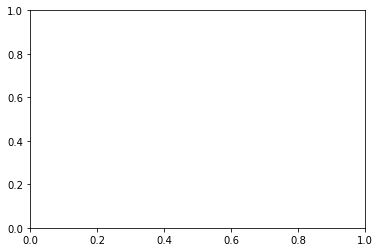

In [105]:
#fig, ax = plt.subplots(1, 1, figsize=(10, 6), subplot_kw=dict(projection=proj))
plt.pcolormesh(lons, lats, np.ma.array(ds["Rad"].values, mask=np.isnan(ds["Rad"])), cmap="Greys")

In [42]:
ds

<xarray.Dataset>
Dimensions:                                 (band: 1, num_star_looks: 24, number_of_image_bounds: 2, number_of_time_bounds: 2, x: 2500, y: 1500)
Coordinates:
  * y                                       (y) float32 0.128212 0.128156 ...
  * x                                       (x) float32 -0.101332 -0.101276 ...
    t                                       datetime64[ns] ...
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_id                                 (band) int8 ...
    band_wavelength                         (band) float32 ...
    t_star_look                             (num_star_looks) datetime64[ns] ...
    band_wavelength_star_look               (num_star_looks) float32 ...
Dimensions without coordinates: band, num_star_looks, number_of_image_bounds, number_of_time_bounds
Data variables:
    Rad                                     (y, x) float32 nan nan nan nan ...
    DQF              

In [57]:
ds["geospatial_lat_lon_extent"]

<xarray.DataArray 'geospatial_lat_lon_extent' ()>
array(9.96921e+36, dtype=float32)
Coordinates:
    t        datetime64[ns] ...
    y_image  float32 0.08624
    x_image  float32 -0.03136
Attributes:
    long_name:                       geospatial latitude and longitude refere...
    geospatial_westbound_longitude:  -152.10928
    geospatial_northbound_latitude:  56.76145
    geospatial_eastbound_longitude:  -52.94688
    geospatial_southbound_latitude:  14.57134
    geospatial_lat_center:           30.083002
    geospatial_lon_center:           -87.096954
    geospatial_lat_nadir:            0.0
    geospatial_lon_nadir:            -75.0
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east

In [58]:
ds["goes_imager_projection"]

<xarray.DataArray 'goes_imager_projection' ()>
array(-2147483647, dtype=int32)
Coordinates:
    t        datetime64[ns] ...
    y_image  float32 0.08624
    x_image  float32 -0.03136
Attributes:
    long_name:                       GOES-R ABI fixed grid projection
    grid_mapping_name:               geostationary
    perspective_point_height:        35786023.0
    semi_major_axis:                 6378137.0
    semi_minor_axis:                 6356752.31414
    inverse_flattening:              298.2572221
    latitude_of_projection_origin:   0.0
    longitude_of_projection_origin:  -75.0
    sweep_angle_axis:                x